# MNIST Prediction with Convolutional Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.
- Reference: [Oddly Satisfying Deep Learning](https://pythonandml.github.io/dlbook/content/convolutional_neural_networks/cnn_over_mlp.html)

#### Import libraries

In [523]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import signal
from keras.datasets import mnist

#### 1. Lib

##### 1.1. Base Layer class

In [524]:
class BaseLayer:
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        :param X: input data

        TODO: return the output of the layer
        """
        pass

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of the loss with respect to the output of the layer
        :param lr: learning rate

        TODO: update parameters and return the gradient of the input
        """
        pass

##### 1.2. Weight Initialization

In [525]:
class WeightInitializer:
    def __init__(self, inp_size: int, out_size: int, act_type: str = None) -> None:
        if act_type is None:
            self.act_type = "random"
        else:
            self.act_type = act_type

        self.inp_size = inp_size
        self.out_size = out_size

    def zeros(self) -> np.ndarray:
        return np.zeros(shape=(self.out_size, self.inp_size))

    def ones(self) -> np.ndarray:
        return np.ones(shape=(self.out_size, self.inp_size))

    def random(self) -> np.ndarray:
        return np.random.randn(self.out_size, self.inp_size)

    def random_uniform(self) -> np.ndarray:
        return np.random.uniform(-1, 1, (self.out_size, self.inp_size))

    def get(self) -> np.ndarray:
        if self.act_type == "zeros":
            return self.zeros()
        elif self.act_type == "ones":
            return self.ones()
        elif self.act_type == "random":
            return self.random()
        elif self.act_type == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError("Invalid activation type")

##### 1.3. Cost Function

In [526]:
class Cost:
    def __init__(self, cost_type: str = "mse") -> None:
        """
        :param cost_type: type of cost function to use (mse, cross_entropy)
        """
        self.cost_type = cost_type

    def mse(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return np.mean((y_true - y_pred) ** 2)

    def d_mse(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return 2 * (y_pred - y_true) / np.size(y_true)

    def cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def d_cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

    def get_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.cost_type == "mse":
            return self.mse(y_true, y_pred)
        elif self.cost_type == "cross_entropy":
            return self.cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Invalid cost type")

    def get_d_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.cost_type == "mse":
            return self.d_mse(y_true, y_pred)
        elif self.cost_type == "cross_entropy":
            return self.d_cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Invalid cost type")

##### 1.4. Preprocessing Data

In [527]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np.eye(2)[y]
    y = y.reshape(len(y), 2, 1)
    return x, y

#### 2. Layers

##### 2.1. Convolutional Layer

##### 2.2. Dense Layer class

In [528]:
class Dense(BaseLayer):
    def __init__(self, inp_size: int, out_size: int) -> None:
        self.weights = WeightInitializer(inp_size, out_size).get()
        self.bias = WeightInitializer(1, out_size).get()

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return np.dot(self.weights, self.X) + self.bias

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dW = np.dot(dZ, self.X.T)
        self.weights -= lr * dW
        self.bias -= lr * dZ
        return np.dot(self.weights.T, dZ)

##### 2.3. Activation Layer class

In [529]:
class Activation(BaseLayer):
    def __init__(self, act_type: str = "reLU") -> None:
        self.act_type = act_type

    def linear(self, X: np.ndarray) -> np.ndarray:
        return X

    def d_linear(self, X: np.ndarray) -> np.ndarray:
        return 1

    def reLU(self, X: np.ndarray) -> np.ndarray:
        return np.maximum(0, X)

    def d_reLU(self, X: np.ndarray) -> np.ndarray:
        return np.where(X > 0, 1, 0)

    def sigmoid(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-X))

    def d_sigmoid(self, X: np.ndarray) -> np.ndarray:
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def tanh(self, X: np.ndarray) -> np.ndarray:
        return np.tanh(X)

    def d_tanh(self, X: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(X) ** 2

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act_type == "linear":
            return self.linear(X)
        elif self.act_type == "reLU":
            return self.reLU(X)
        elif self.act_type == "sigmoid":
            return self.sigmoid(X)
        elif self.act_type == "tanh":
            return self.tanh(X)
        else:
            raise ValueError("Invalid activation type")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act_type == "linear":
            return self.d_linear(X)
        elif self.act_type == "reLU":
            return self.d_reLU(X)
        elif self.act_type == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act_type == "tanh":
            return self.d_tanh(X)
        else:
            raise ValueError("Invalid activation type")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return self.get_activation(self.X)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.multiply(dZ, self.get_d_activation(self.X))

##### 2.4. Convolutional Layer class

In [530]:
class Conv2D(BaseLayer):
    def __init__(
        self, inp_shape: tuple[int, int, int], kernel_size: int = 3, depth: int = 1
    ):
        """
        :param inp_shape: shape of the input data
        :param kernel_size: size of the kernel
        :param depth: depth of the output data
        """
        inp_depth, inp_height, inp_width = inp_shape
        self.depth = depth
        self.inp_shape = inp_shape
        self.inp_depth = inp_depth

        self.out_shape = (
            depth,
            inp_height - kernel_size + 1,
            inp_width - kernel_size + 1,
        )
        self.kernels_shape = (depth, inp_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.bias = np.random.randn(*self.out_shape)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.output = np.copy(self.bias)

        for row in range(self.depth):
            for col in range(self.inp_depth):
                self.output[row] += signal.convolve2d(
                    self.X[col], self.kernels[row, col], mode="valid"
                )

        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dK = np.zeros(self.kernels_shape)
        dX = np.zeros(self.inp_shape)

        for row in range(self.depth):
            for col in range(self.inp_depth):
                dK[row, col] = signal.convolve2d(self.X[col], dZ[row], mode="valid")
                dX[col] += signal.convolve2d(
                    dZ[row], self.kernels[row, col], mode="full"
                )
        self.kernels -= lr * dK
        self.bias -= lr * dZ
        return dX

##### 2.5. Reshape Layer class

In [531]:
class Reshape(BaseLayer):
    def __init__(self, inp_shape, out_shape) -> None:
        self.inp_shape = inp_shape
        self.out_shape = out_shape

    def forward(self, X: np.ndarray) -> np.ndarray:
        return np.reshape(X, self.out_shape)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.reshape(dZ, self.inp_shape)

#### 3. Convolutional Neural Network (CNN) Model class

In [532]:
class CNN:
    def __init__(self, layers: list[BaseLayer]) -> None:
        if not layers:
            raise ValueError("No layers provided")
        else:
            self.layers = layers

        self.layer_name = []
        self.architecture = []

    def create_network_architecture(self):
        for layer in self.layers:
            if layer.__class__.__name__ == "Conv2D":
                self.layer_name.append("Conv2D")
                self.architecture.append(layer.kernels_shape)
            elif layer.__class__.__name__ == "Dense":
                self.layer_name.append("Dense")
                self.architecture.append(layer.weights.shape)
            elif layer.__class__.__name__ == "Activation":
                self.layer_name.append("Activation")
                self.architecture.append(None)
            elif layer.__class__.__name__ == "Reshape":
                self.layer_name.append("Reshape")
                self.architecture.append(layer.out_shape)

    def compile(self, cost_type: str, lr: float, verbose: bool = True) -> None:
        """
        :param cost_type: type of cost function to use (mse, cross_entropy)
        :param lr: learning rate
        :param verbose: whether to print the cost and accuracy after each epoch
        """
        self.cost = Cost(cost_type)
        self.lr = lr
        self.verbose = verbose

    def summary(self) -> None:
        self.create_network_architecture()
        len_assigned = [45, 26, 15]
        count = {
            "Dense": 1,
            "Activation": 1,
            "Conv2D": 1,
            "Reshape": 1,
        }
        col_names = ["Layer (type)", "Output Shape", "Param #"]
        print("Model: CNN")
        print("-" * sum(len_assigned))

        text = ""
        for i in range(3):
            text += col_names[i] + " " * (len_assigned[i] - len(col_names[i]))
        print(text)
        print("=" * sum(len_assigned))

        total_params = 0
        for i in range(len(self.layer_name)):
            layer_name = self.layer_name[i]
            name = f"{layer_name.lower()}_{count[layer_name]} ({layer_name})"

            count[layer_name] += 1
            if self.architecture[i] is None:
                print(
                    f"{name}{' ' * (len_assigned[0] - len(name))}{' ' * (len_assigned[1] - 2)}{' ' * (len_assigned[2] - 2)}"
                )
                continue

            total_params += np.prod(self.architecture[i])
            output_shape = self.architecture[i]
            output_shape = f"({', '.join(map(str, output_shape))})"
            params = np.prod(self.architecture[i])

            print(
                f"{name}{' ' * (len_assigned[0] - len(name))}{output_shape}{' ' * (len_assigned[1] - len(output_shape))}{params}"
            )

        print("=" * sum(len_assigned))

        print(f"Total params: {total_params}")
        print(f"Cost function: {self.cost.cost_type}")
        print(f"Learning rate: {self.lr}")
        print(f"Verbose: {self.verbose}")
        print("-" * sum(len_assigned))

    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000) -> None:
        self.history = {"cost": [], "accuracy": []}

        for epoch in range(epochs):
            error = 0
            correct = 0

            print(f"Epoch {epoch + 1}/{epochs}")
            for i in tqdm(range(len(X))):
                output = X[i]
                for layer in self.layers:
                    output = layer.forward(output)

                error += self.cost.get_cost(y[i], output)
                correct += int(np.argmax(output) == np.argmax(y[i]))

                dZ = self.cost.get_d_cost(y[i], output)
                for layer in reversed(self.layers):
                    dZ = layer.backpropagation(dZ, self.lr)

            self.history["cost"].append(error / len(X))
            self.history["accuracy"].append(correct / len(X))

            if self.verbose:
                print(
                    f"Cost: {self.history['cost'][-1]:.4f}, Accuracy: {self.history['accuracy'][-1]:.4f}"
                )

    def plot_history(self) -> None:
        _, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].plot(self.history["cost"])
        ax[0].set_title("Cost")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Cost")

        ax[1].plot(self.history["accuracy"])
        ax[1].set_title("Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")

        plt.tight_layout()
        plt.show()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = []
        for i in range(len(X)):
            output = X[i]
            for layer in self.layers:
                output = layer.forward(output)
            predictions.append(output)

        return np.array(predictions)

#### 4. Training the model

In [533]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [534]:
X_train, y_train = preprocess_data(X_train, y_train, 1000)
X_test, y_test = preprocess_data(X_test, y_test, 100)

In [535]:
model = CNN(
    [
        Conv2D((1, 28, 28), 3, 5),
        Activation(act_type="sigmoid"),
        Reshape((5, 26, 26), (5 * 26 * 26, 1)),
        Dense(5 * 26 * 26, 100),
        Activation(act_type="sigmoid"),
        Dense(100, 2),
        Activation(act_type="sigmoid"),
    ]
)

model.compile(cost_type="cross_entropy", lr=0.01)

In [536]:
model.summary()

Model: CNN
--------------------------------------------------------------------------------------
Layer (type)                                 Output Shape              Param #        
conv2d_1 (Conv2D)                            (5, 1, 3, 3)              45
activation_1 (Activation)                                                         
reshape_1 (Reshape)                          (3380, 1)                 3380
dense_1 (Dense)                              (100, 3380)               338000
activation_2 (Activation)                                                         
dense_2 (Dense)                              (2, 100)                  200
activation_3 (Activation)                                                         
Total params: 341625
Cost function: cross_entropy
Learning rate: 0.01
Verbose: True
--------------------------------------------------------------------------------------


In [537]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


100%|██████████| 2000/2000 [00:04<00:00, 415.82it/s]


Cost: 0.2404, Accuracy: 0.9570
Epoch 2/10


100%|██████████| 2000/2000 [00:04<00:00, 402.52it/s]


Cost: 0.0708, Accuracy: 0.9920
Epoch 3/10


100%|██████████| 2000/2000 [00:05<00:00, 397.51it/s]


Cost: 0.0461, Accuracy: 0.9945
Epoch 4/10


100%|██████████| 2000/2000 [00:03<00:00, 559.69it/s]


Cost: 0.0346, Accuracy: 0.9950
Epoch 5/10


100%|██████████| 2000/2000 [00:04<00:00, 488.33it/s]


Cost: 0.0292, Accuracy: 0.9945
Epoch 6/10


100%|██████████| 2000/2000 [00:04<00:00, 460.53it/s]


Cost: 0.0267, Accuracy: 0.9945
Epoch 7/10


100%|██████████| 2000/2000 [00:04<00:00, 482.48it/s]


Cost: 0.0245, Accuracy: 0.9945
Epoch 8/10


100%|██████████| 2000/2000 [00:05<00:00, 393.06it/s]


Cost: 0.0228, Accuracy: 0.9940
Epoch 9/10


100%|██████████| 2000/2000 [00:04<00:00, 438.34it/s]


Cost: 0.0210, Accuracy: 0.9945
Epoch 10/10


100%|██████████| 2000/2000 [00:07<00:00, 278.39it/s]

Cost: 0.0191, Accuracy: 0.9950


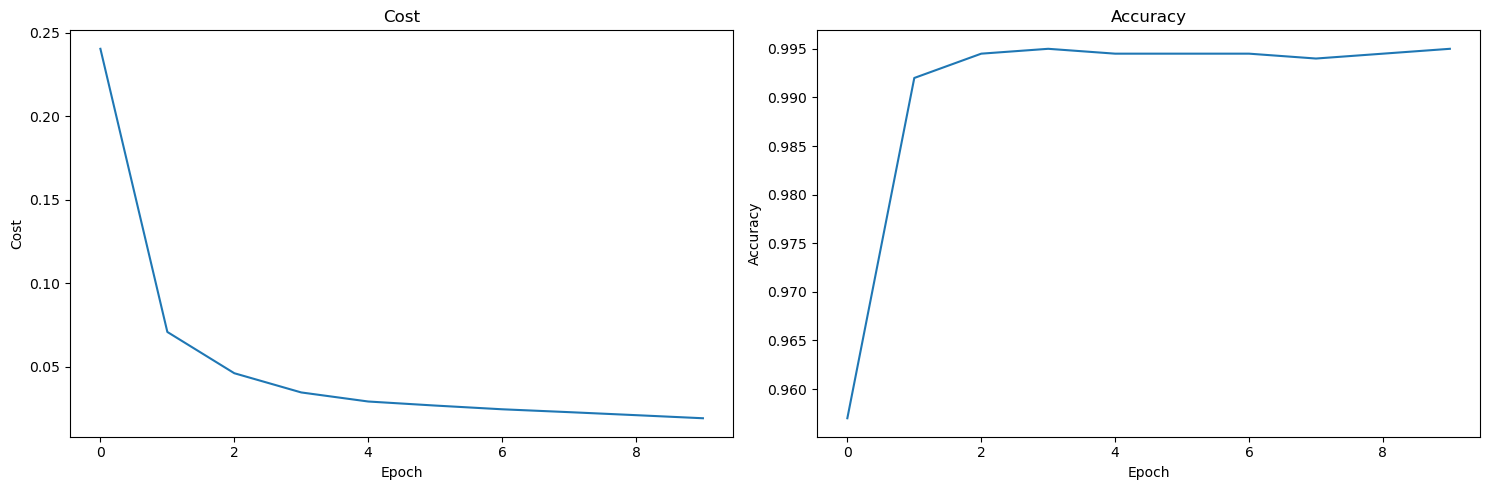

In [538]:
model.plot_history()

In [539]:
y_pred = model.predict(X_test)

print(f"Accuracy: {np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))}")

Accuracy: 1.0
